###  End-to-end Machine Learning project
Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

This notebook contains all the sample code and solutions to the exercices in chapter 2 of [Hands on Machine Learning with Scikit-learn and Tensorflow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291)

### Setup
First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Get the Data

It is best practice to create these functions in a separate python file. But for the sake of this exercise, we will use this notebook. 

In [16]:
DATASETS_URL = "https://github.com/ageron/handson-ml/raw/master/datasets"

In [21]:
import os
import tarfile
from six.moves import urllib

HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [22]:
fetch_housing_data()

Now let's load the data using Pandas

In [23]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [24]:
housing = load_housing_data()
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [26]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Note that "total_bedrooms" attribute has onlye 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later.

Also, notice that all attributes are numberical expect the ocean_proximity field. Its type is object, so it could hold any kind of Python object. But since we loaded this data from a csv file we know that it must be a text attribute. We also saw that in the dataframe above. It looks repetitive value which could be a categorical attirbute. Now, let's dive deeper into this attribute to understand its properties.

In [27]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [29]:
# Let's look at the other fields using describe() method to show a summary of the numerical values
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111402dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x104b36470>]], dtype=object)

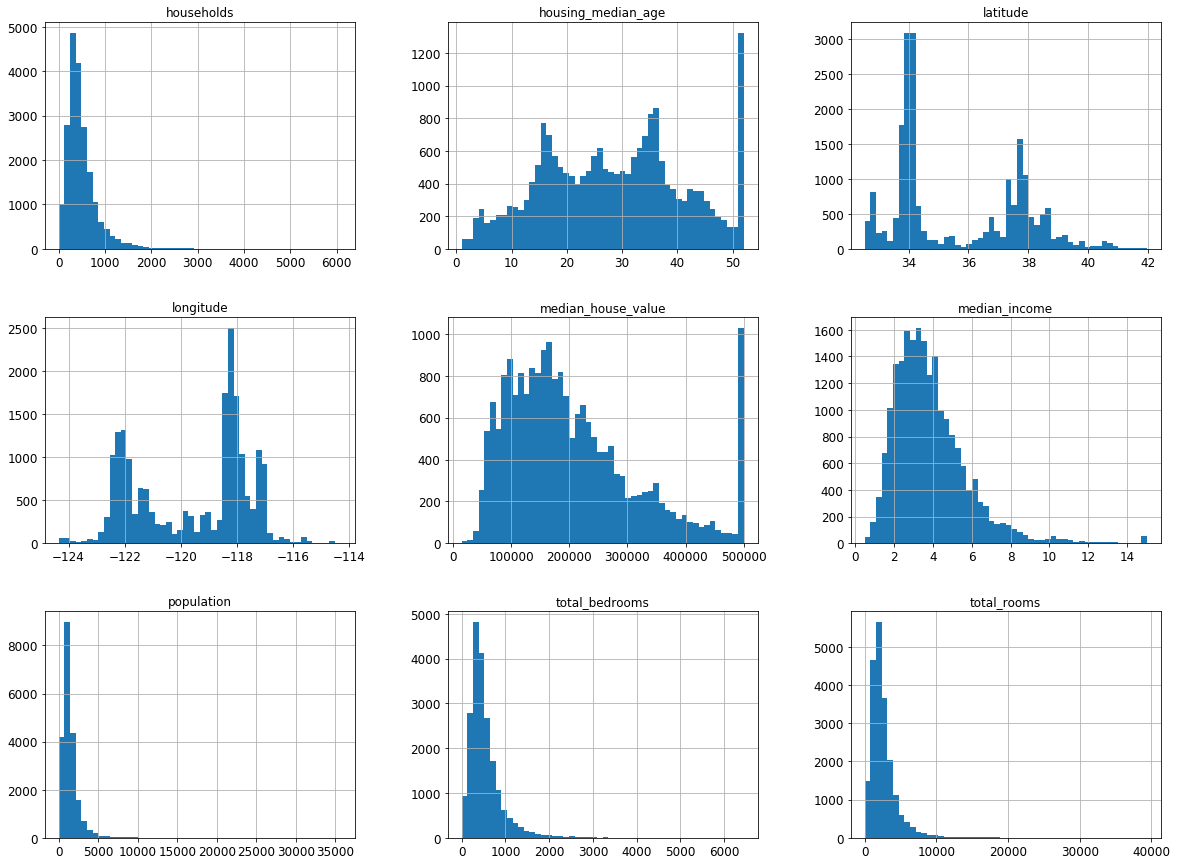

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))

In [32]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [36]:
train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.582290,35.643149,28.608285,2642.004784,538.496851,1426.453004,499.986919,3.880754,207194.693738
std,2.005654,2.136665,12.602499,2174.646744,419.007096,1137.056380,380.967964,1.904294,115622.626448
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.810000,33.930000,18.000000,1454.000000,296.750000,789.000000,280.000000,2.566700,119800.000000
50%,-118.510000,34.260000,29.000000,2129.000000,437.000000,1167.000000,410.000000,3.545800,179850.000000
75%,-118.010000,37.720000,37.000000,3160.000000,647.000000,1726.000000,606.000000,4.773175,265125.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [35]:
test_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.00000,4128.00000,4128.000000,4128.000000,3921.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.51936,35.58671,28.764293,2610.796269,535.233104,1421.571705,497.750727,3.830338,205500.309593
std,1.99447,2.13276,12.518304,2209.359101,431.299704,1114.023136,387.770570,1.881515,114486.964288
min,-124.19000,32.54000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000
25%,-121.69000,33.93000,18.000000,1420.000000,294.000000,781.000000,278.000000,2.548500,119275.000000
50%,-118.47000,34.23000,29.000000,2110.000000,428.000000,1160.000000,406.000000,3.500000,178650.000000
75%,-117.99000,37.70000,37.000000,3099.250000,643.000000,1722.000000,598.000000,4.645925,263000.000000
max,-114.58000,41.81000,52.000000,37937.000000,5471.000000,16122.000000,5189.000000,15.000100,500001.000000


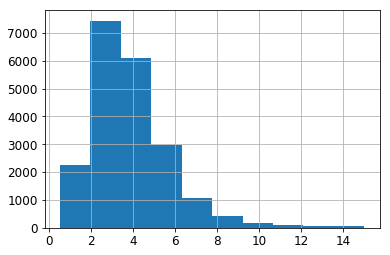

In [37]:
housing['median_income'].hist()

In [41]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [43]:
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

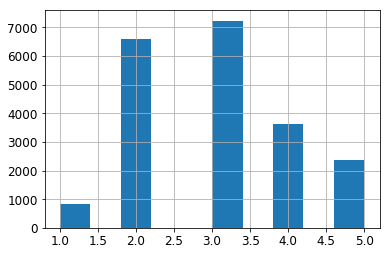

In [44]:
housing['income_cat'].hist()

In [45]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [46]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [47]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [48]:
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

In [51]:
housing = strat_train_set.copy()

In [52]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


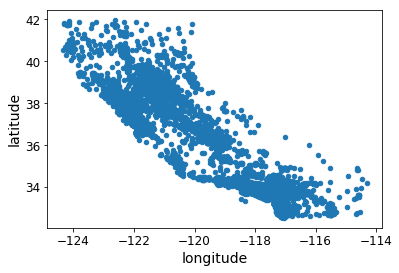

In [53]:
housing.plot(x="longitude", y="latitude", kind="scatter")

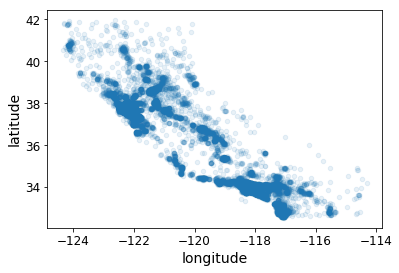

In [56]:
housing.plot(x="longitude", y="latitude", kind="scatter", alpha=0.1)

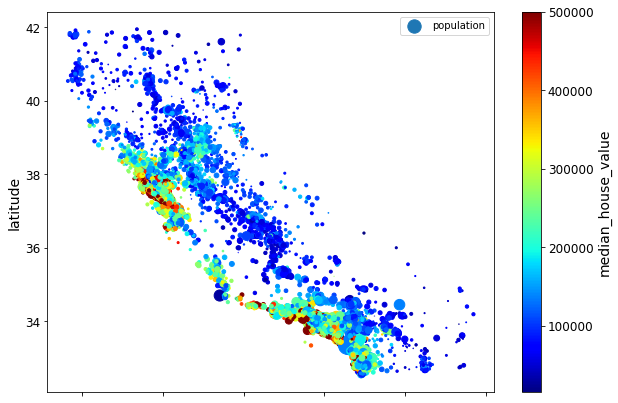

In [59]:
housing.plot(x="longitude", y="latitude", kind="scatter",
            s=housing['population']/100, label="population",
            figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"),
            colorbar=True
            )
plt.legend()

### Looking for correlations
Since the dataset is not too large, we can easily compute the standard correlation coefficient between every pair of attributes.

In [60]:
corr_matrix = housing.corr()

In [61]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way to check for correlation is to use Panda's scatter_matrix:

In [62]:
from pandas.tools.plotting import scatter_matrix

/Users/moelgendy/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  from ipykernel import kernelapp as app


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1174f20f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117e6c518>]], dtype=object)

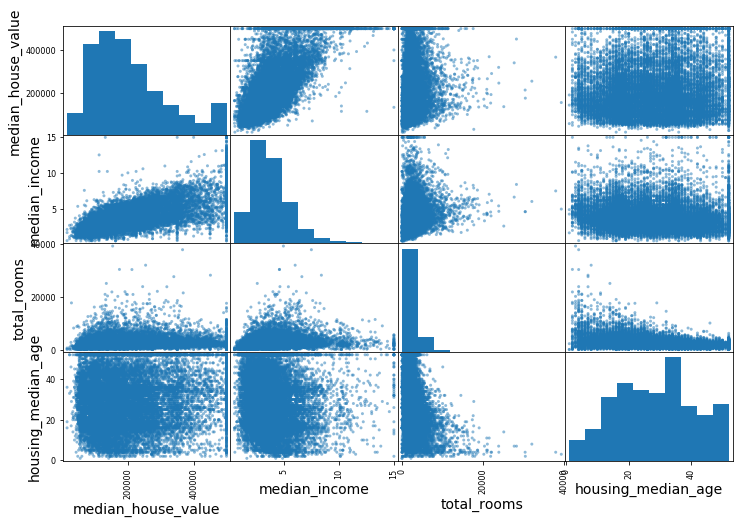

In [63]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

Looks like the most promising attribute to predict the median house value is the median income. Let's zoom in on their correlation scatterplot.

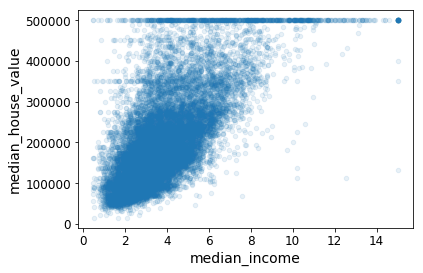

In [64]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveals a few things:
1. The correlation is indeed very strong, you can cleaely see the upward tren and the points are not too dispersed
2. The price cap is clearly visible as a horizontal line at 500,000
3. The plot reveals other less obvious straight lines at 450,000 and 350,000 and maybe 280,000. We might want to try removing the corresponding districts to prevent our algorithm from learning to reproduct these data quirks.

In [65]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["population"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [66]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.199429
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the data for Machine Learning algorithms

In [67]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [68]:
from sklearn.preprocessing import Imputer

In [69]:
imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [70]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [71]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [72]:
# Now we can use this trained imputer to transform set by replaceing all the missing value by the learned medians
X = imputer.transform(housing_num)

In [73]:
# the result is a plain Numpy array containing the transformed features
X

array([[ -121.89  ,    37.29  ,    38.    , ...,   710.    ,   339.    ,
            2.7042],
       [ -121.93  ,    37.05  ,    14.    , ...,   306.    ,   113.    ,
            6.4214],
       [ -117.2   ,    32.77  ,    31.    , ...,   936.    ,   462.    ,
            2.8621],
       ..., 
       [ -116.4   ,    34.09  ,     9.    , ...,  2098.    ,   765.    ,
            3.2723],
       [ -118.01  ,    33.82  ,    31.    , ...,  1356.    ,   356.    ,
            4.0625],
       [ -122.45  ,    37.77  ,    52.    , ...,  1269.    ,   639.    ,
            3.575 ]])

In [74]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [76]:
imputer.strategy

'median'

In [81]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [82]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
encoder.fit_transform(housing_cat)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_pipeline.fit_transform(housing_num)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [83]:
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [84]:
housing_prepared = preparation_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [85]:
housing_prepared.shape

(16512, 16)

## Select and train a model

In [86]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [87]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = preparation_pipeline.transform(some_data)

print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [88]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [89]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018973

In [90]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Fine-tune your model

In [91]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

In [92]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 68292.14894598  66782.53562278  70759.47269143  69889.91977163
  70589.76882605  74182.94790873  71548.27958524  70250.63692186
  76559.98348136  69500.68470599]
Mean: 70835.6378461
Standard deviation: 2654.47566618


In [93]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [94]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22273.360483461016

In [95]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52358.66679404  49743.79903788  51335.21486934  54925.88657132
  52257.98169035  55720.86291923  52842.69505175  50082.9703802
  55483.30713101  53171.12873845]
Mean: 52792.2513184
Standard deviation: 1993.65740926


In [96]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [97]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [98]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [99]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [100]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [101]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64755.2777758 {'n_estimators': 3, 'max_features': 2}
55506.9655961 {'n_estimators': 10, 'max_features': 2}
53003.625756 {'n_estimators': 30, 'max_features': 2}
60398.3535618 {'n_estimators': 3, 'max_features': 4}
52727.4104238 {'n_estimators': 10, 'max_features': 4}
50621.458375 {'n_estimators': 30, 'max_features': 4}
58477.4098159 {'n_estimators': 3, 'max_features': 6}
52390.5465404 {'n_estimators': 10, 'max_features': 6}
49739.2504479 {'n_estimators': 30, 'max_features': 6}
59701.4574011 {'n_estimators': 3, 'max_features': 8}
52283.7251457 {'n_estimators': 10, 'max_features': 8}
50118.0805161 {'n_estimators': 30, 'max_features': 8}
63566.613601 {'n_estimators': 3, 'max_features': 2, 'bootstrap': False}
54624.5516492 {'n_estimators': 10, 'max_features': 2, 'bootstrap': False}
59843.2111247 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
52550.4008218 {'n_estimators': 10, 'max_features': 3, 'bootstrap': False}
58775.9386056 {'n_estimators': 3, 'max_features': 4, 'bootstrap':

In [102]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.068133,0.004591,-4.193246e+09,-1.107368e+09,NaN,2,3,"{'n_estimators': 3, 'max_features': 2}",18,-3.749000e+09,...,-4.251975e+09,-1.086999e+09,-4.233260e+09,-1.166776e+09,-4.134733e+09,-1.049429e+09,0.005718,0.000770,2.717100e+08,4.858923e+07
1,0.214783,0.011958,-3.081023e+09,-5.880830e+08,NaN,2,10,"{'n_estimators': 10, 'max_features': 2}",11,-2.900398e+09,...,-3.206039e+09,-5.885562e+08,-2.856323e+09,-5.744495e+08,-3.140649e+09,-5.795606e+08,0.012656,0.001426,1.737828e+08,1.550720e+07
2,0.653281,0.048430,-2.809384e+09,-4.351502e+08,NaN,2,30,"{'n_estimators': 30, 'max_features': 2}",9,-2.662552e+09,...,-2.872159e+09,-4.305071e+08,-2.667413e+09,-4.375747e+08,-2.865955e+09,-4.295404e+08,0.037892,0.027966,1.245603e+08,8.363872e+06
3,0.103779,0.004084,-3.647961e+09,-9.542137e+08,NaN,4,3,"{'n_estimators': 3, 'max_features': 4}",16,-3.449042e+09,...,-3.772008e+09,-9.431475e+08,-3.260556e+09,-8.972530e+08,-4.031105e+09,-9.692611e+08,0.002933,0.000419,2.676105e+08,3.278348e+07
4,0.390166,0.021266,-2.780180e+09,-5.230046e+08,NaN,4,10,"{'n_estimators': 10, 'max_features': 4}",8,-2.572784e+09,...,-2.861942e+09,-5.158335e+08,-2.639026e+09,-5.332063e+08,-2.985589e+09,-5.251764e+08,0.077402,0.014179,1.520449e+08,7.795560e+06
5,1.110044,0.043824,-2.562532e+09,-3.907497e+08,NaN,4,30,"{'n_estimators': 30, 'max_features': 4}",3,-2.398337e+09,...,-2.674806e+09,-3.794815e+08,-2.453765e+09,-3.965548e+08,-2.654437e+09,-3.936350e+08,0.096374,0.020375,1.136479e+08,5.885101e+06
6,0.162566,0.005845,-3.419607e+09,-8.989187e+08,NaN,6,3,"{'n_estimators': 3, 'max_features': 6}",12,-3.234966e+09,...,-3.661518e+09,-9.243260e+08,-3.171243e+09,-8.523596e+08,-3.547216e+09,-9.203640e+08,0.034742,0.003197,1.868728e+08,2.708198e+07
7,0.469809,0.011810,-2.744769e+09,-5.053849e+08,NaN,6,10,"{'n_estimators': 10, 'max_features': 6}",6,-2.602115e+09,...,-2.895539e+09,-4.733642e+08,-2.526804e+09,-5.060352e+08,-2.790649e+09,-5.312679e+08,0.003160,0.000251,1.546477e+08,1.892124e+07
8,1.402975,0.031782,-2.473993e+09,-3.784114e+08,NaN,6,30,"{'n_estimators': 30, 'max_features': 6}",1,-2.352285e+09,...,-2.621855e+09,-3.726925e+08,-2.309890e+09,-3.926282e+08,-2.588304e+09,-3.752015e+08,0.027792,0.002740,1.242805e+08,8.305325e+06
9,0.178728,0.004121,-3.564264e+09,-9.091755e+08,NaN,8,3,"{'n_estimators': 3, 'max_features': 8}",14,-3.409840e+09,...,-3.708036e+09,-8.908705e+08,-3.459225e+09,-9.481037e+08,-3.712153e+09,-8.923053e+08,0.004890,0.000551,1.252618e+08,2.278030e+07


In [103]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error')
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11fc3da90>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11fc3d860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [104]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

75827.0127384 {'n_estimators': 1, 'max_features': 6}
51773.4029097 {'n_estimators': 177, 'max_features': 2}
49210.3696644 {'n_estimators': 141, 'max_features': 5}
49309.2713809 {'n_estimators': 165, 'max_features': 5}
54984.0825428 {'n_estimators': 73, 'max_features': 1}
50867.1273268 {'n_estimators': 14, 'max_features': 7}
49692.0863741 {'n_estimators': 127, 'max_features': 4}
49235.9999788 {'n_estimators': 166, 'max_features': 5}
49331.259819 {'n_estimators': 78, 'max_features': 6}
54805.7756024 {'n_estimators': 81, 'max_features': 1}


In [105]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  8.28144388e-02,   7.40091656e-02,   4.15240599e-02,
         1.80941185e-02,   1.60701514e-02,   1.76932152e-02,
         1.59013238e-02,   3.27226121e-01,   6.38692743e-02,
         1.07170346e-01,   5.83381349e-02,   2.07419879e-02,
         1.46352905e-01,   4.17814494e-05,   5.36202879e-03,
         4.79094778e-03])

In [106]:
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32722612106782478, 'median_income'),
 (0.14635290499528966, 'INLAND'),
 (0.10717034569827505, 'population_per_household'),
 (0.082814438794139328, 'longitude'),
 (0.074009165612934372, 'latitude'),
 (0.063869274281907043, 'rooms_per_household'),
 (0.058338134861887762, 'bedrooms_per_room'),
 (0.041524059862640531, 'housing_median_age'),
 (0.020741987915756897, '<1H OCEAN'),
 (0.018094118483344399, 'total_rooms'),
 (0.017693215157375576, 'population'),
 (0.016070151406094572, 'total_bedrooms'),
 (0.015901323845072975, 'households'),
 (0.0053620287930892969, 'NEAR BAY'),
 (0.0047909477750053223, 'NEAR OCEAN'),
 (4.1781449362410541e-05, 'ISLAND')]

In [107]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_transformed = preparation_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_transformed)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47532.724761112506

# THE END